## Benchmark: ARIMA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MSE, MAE, MAPE

%matplotlib inline
import os
import sys
import platform
if platform.node() in ['msbq']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
from utils import get_fx_and_metric_data, get_fx_and_metric_data_wo_weekend, mde
from benchmark_utils import ts_train_test_normalize


/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Functions

In [2]:
def actual_pred_plot(preds, y_test):
    '''
    Plot the actual vs. prediction
    '''
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['prediction'] = preds[:,0]
    actual_pred['Adj. Close'] = y_test[:,0]  #.loc['2019':,'Adj Close'][0:len(preds)]

    from tensorflow.keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    return (m.result().numpy(), actual_pred.plot() )

In [45]:
from utils import data_merge, data_read_dict
def __get_fx_and_metric_data_wo_weekend(
    *,
    pct_change:bool=True,
    dtype:np.float=None,
    directory='data',
    directory_metrics=None,
    sep=',',
    enddate='2022-02-01'
) -> pd.DataFrame:
    """Gets the FX spot rates and combines data with metrics, without missing values on weekends (and bank holidays).

    Args:
        pct_change (bool, optional): Returns percantage change. Defaults to True.
        dtype (numpy.float, optional): data type of data, options 'numpy.floatX'. Defaults to None.

    Returns:
        pd.DataFrame: Spot rates and metrics in one pandas.DataFrame
    """
    path = os.path.join(directory, '10min Dataset Spot.csv')
    df = pd.read_csv(path, delimiter=sep)
    df['Dates'] = pd.to_datetime(df['Dates'], format='%d.%m.%y %H:%M')
    df.set_index('Dates', inplace=True)
    # df = df.asfreq('600S')
    if pct_change:
        df = df.pct_change()[1:]
    # assert len(set(np.diff(df.index.values))) == 1

    FX_Fundamentals_path = os.path.join(directory, '10min Dataset Rest.csv')
    df2 = pd.read_csv(FX_Fundamentals_path, delimiter=sep)
    df2.replace(to_replace=0, method='ffill', inplace=True) # Replace 0 to avoid dividing by 0 later on
    df2.drop('UXA1 Comdty Trade Open', axis=1, inplace=True)
    df2['Dates'] = pd.to_datetime(df2['Dates'], format='%d.%m.%y %H:%M')
    df2.sort_values('Dates', inplace=True)
    df2.sort_values('Dates')
    df2.index = df2['Dates']

    # df3
    df3 = pd.merge(df, df2, left_index=True, right_index=True)
    df3['Dates'] = pd.to_datetime(df3['Dates'], format='%d.%m.%y %H:%M')
    df3.index = df3['Dates']

    df_metrics = data_merge(data_read_dict(os.path.join(directory_metrics, 'bbg')))
    df_metrics.shape
    # excluding eurgbp for now
    df_metrics = df_metrics.loc[:, [i for i in df_metrics.columns if i.split('___')[0].lower() != 'eurgbp']]
#     df_merged = pd.merge(df3, df_metrics, left_index=True, right_index=True, how='outer')
    df_merged = df3.join(df_metrics)
    
    # Deleting all rows that have missing values in df and df2 columns
    df_merged = df_merged.loc[~df_merged.loc[:, set(df.columns.append(df2.columns))].isna().all(axis=1)]

    # Deleting all columns with duplicated data that occur on the weekend
    #(np.diff(df_merged.loc[:, df.columns], prepend=-9999) == 0).mean(axis=1) < 0.95
    duplicates = df_merged.loc[:, df.columns].duplicated()
    weekend = [i.weekday() in [5, 6] for i in df_merged.index]
    # sum(duplicates)
    # sum(weekend)
    # sum(duplicates & weekend)
    # sum(duplicates | weekend)
    df_merged = df_merged.loc[~(duplicates & weekend), :]

    df = df_merged[:]
    df.drop('Dates', axis=1, inplace=True)
    # df = df.asfreq('600S')
    df = df.ffill()
    df = df.loc[(df.index >= '2020-11-01') & (df.index < enddate), :]
    #TODO: There will still be NA values (metric values) in the beginning, possible fixes:
    df = df.bfill()  # back fill
    # df.dropna(how='all', axis=0, inplace=True)  # Drop all rows with NaN values"
    # df.fillna(0, inplace=True)  # impute all NaNs with 0
    df = df.astype(dtype)    
    del df_merged, df2, df3
    return df

### Data

In [46]:
df = __get_fx_and_metric_data_wo_weekend(dtype=np.float32, directory='data/1h_Dataset', directory_metrics='data')

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Create training and test data for RNN/LSTM

In [49]:
target_column = list(df.columns).index('EURUSD BGNE Curncy Bid Close')
lag = 1
h = 1
dtype = np.float32  # np.float64
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, target_column, dtype=dtype)

In [50]:
y_test.shape

(806, 1)

## ARIMA

In [51]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import yule_walker

#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pmd

In [52]:
p = adfuller(X_train[:, 0, target_column])[1]
print("p-value:", p)
print(f"Differencing is {'' if p > 0.05 else 'not '}necessary")

p-value: 0.0
Differencing is not necessary


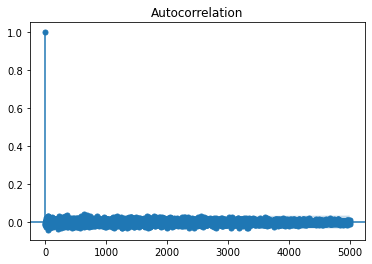

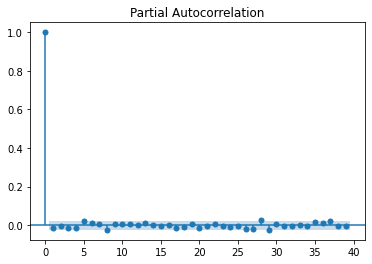

In [53]:
plot_acf(X_train[:, 0, target_column], lags=5000)  # ACF
# plt.ylim(0, 0.2)
plt.show()
plot_pacf(X_train[:, 0, target_column])
# plt.ylim(-0.1, 0.1)
plt.show()

In [54]:
g = grangercausalitytests(X_train[:, 0, target_column:(target_column+2)], maxlag =10, verbose = 0)
g[1]

({'ssr_ftest': (7.249741985905782, 0.007109408215744998, 6461.0, 1),
  'ssr_chi2test': (7.253108218061442, 0.007077839512403737, 1),
  'lrtest': (7.249041985174699, 0.007093884901760969, 1),
  'params_ftest': (7.2497419859030074, 0.0071094082157558205, 6461.0, 1.0)},
  array([[0., 1., 0.]])])

In [55]:
print(f"ndiffs: {pmd.arima.ndiffs(X_train[:, 0, target_column])}")
print(f"nsdiffs: {pmd.arima.nsdiffs(X_train[:, 0, target_column], m=2)}")

ndiffs: 0
nsdiffs: 0


In [62]:
# # see https://www.pluralsight.com/guides/advanced-time-series-modeling-(arima)-models-in-python
arima = pmd.auto_arima(
    X_train[:, 0, target_column],
    d=pmd.arima.ndiffs(X_train[:, 0, target_column]),
    start_p=0,
    max_p=20,
    start_q=0,
    max_q=20,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    test='adf',
    trace=True
)
arima

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=18352.867, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18353.956, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=18353.944, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18350.867, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=18356.395, Time=1.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.713 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [63]:
# arima_order = arima.get_params()['order']
arima_order = (1, 0, 1)
# arima_order_season = arima.get_params()['seasonal_order']
arima_order_season = (0, 0, 0, 0)

In [64]:
mod = sm.tsa.arima.ARIMA(
    X_train[:,0, target_column],
#     exog=X_train[:,0, [i for i in range(min(10, X_train.shape[2])) if i !=3]],
    order=arima_order,
    seasonal_order=arima_order_season
)
model_train = mod.fit()
print(model_train.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6465
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -9174.198
Date:                Tue, 31 May 2022   AIC                          18356.395
Time:                        16:55:36   BIC                          18383.492
Sample:                             0   HQIC                         18365.770
                               - 6465                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.617e-05      0.012     -0.006      0.996      -0.023       0.023
ar.L1          0.9682      0.080     12.058      0.000       0.811       1.126
ma.L1         -0.9703      0.078    -12.454      0.0

In [65]:
from sklearn.metrics import r2_score
r2_score(X_train[:,0, target_column], model_train.predict())

7.303035301742256e-05

In [66]:
y_train_pred = model_train.predict()
# y_train_pred = sc_target.inverse_transform(y_train_pred)

In [67]:
m_min = np.min([y_train.min(), y_train_pred[y_train_pred != 0].min()])
m_max = np.max([y_train.max(), y_train_pred.max()])

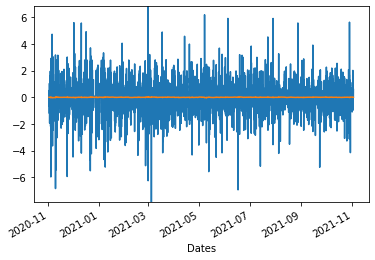

In [68]:
pd.Series(
    data=y_train[:, 0],
    index=index_train[-y_train_pred.shape[0]:],
).plot()
pd.Series(
    data=y_train_pred,
    index=index_train[-y_train_pred.shape[0]:],
).plot()
plt.ylim(m_min, m_max)
plt.show()

In [69]:
y_pred_error = pd.Series(
    data=y_train_pred.flatten() - y_train.flatten(),
    index=index_train[-y_train_pred.shape[0]:],
).iloc[1:]

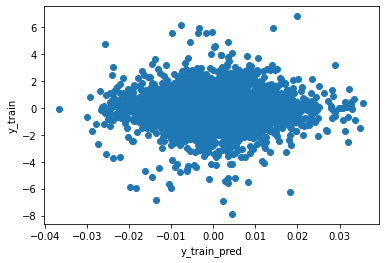

Text(0.5, 1.0, 'QQ-lot for y_train_pred - y_train')

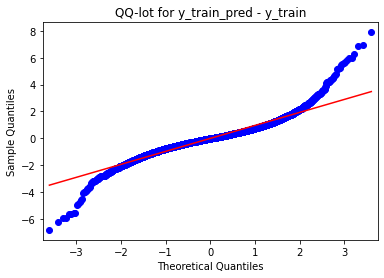

In [70]:
# y_pred_error.plot()
# plt.show()
plt.scatter(y_train_pred[1:], y_train[1:])
plt.xlabel('y_train_pred')
plt.ylabel('y_train')
plt.show()
import statsmodels.api as smi
smi.qqplot(y_pred_error[1:], line = "r")
plt.title('QQ-lot for y_train_pred - y_train')
# pylab.show()

In [71]:
y = y_train
# y = sc_target.inverse_transform(y_train)
y_pred = y_train_pred
# y_pred = sc_target.inverse_transform(y_train_pred)
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')

mse: 1.000282859938569
mae: 0.6844156793275731
mape: 124.6995037647225
mde: 0.2386191840873444


In [72]:
# y = y_train
y = sc_target.inverse_transform(y_train)
# y_pred = y_train_pred
y_pred = sc_target.inverse_transform(y_train_pred)
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')

mse: 4.991333021233067e-07
mae: 0.00048346697145786787
mape: 171.36512154932632
mde: 0.2386191840873444


In [73]:
mod2 = sm.tsa.arima.ARIMA(
    X_test[:, 0, target_column],
#     exog=X_test[:,0, [i for i in range(min(10, X_test.shape[2])) if i !=3]],
    order=arima_order,
    seasonal_order=arima_order_season
)
with mod2.fix_params(dict(zip(model_train.param_names, model_train.params))):
    model_test = mod2.fit()
print(model_test.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  806
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1170.714
Date:                Tue, 31 May 2022   AIC                           2341.428
Time:                        16:55:42   BIC                           2341.428
Sample:                             0   HQIC                          2341.428
                                - 806                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const (fixed)  -6.617e-05        nan        nan        nan         nan         nan
ar.L1 (fixed)      0.9682        nan        nan        nan         nan         nan
ma.L1 (fixed)     -0.9703        nan

Get model for test data.

(1.0671582, <AxesSubplot:>)

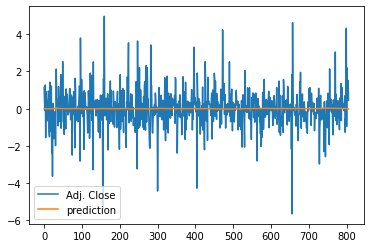

In [74]:
actual_pred_plot(model_test.predict().reshape([-1,1]), X_test[:, 0, 3:4])

<AxesSubplot:xlabel='Dates'>

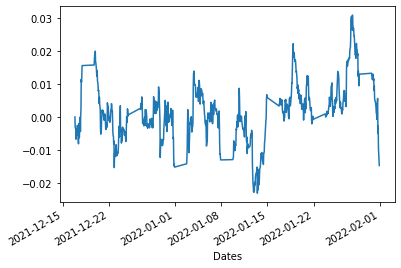

In [75]:
y_test_pred = pd.Series(
    data=model_test.predict(),
    index=index_test[-model_test.predict().shape[0]:],
)
y_test_pred.plot()

In [76]:
# y = y_test
y = sc_target.inverse_transform(y_test)
# y_pred = y_test_pred.values
y_pred = sc_target.inverse_transform(y_test_pred.values)
print(f'mse: {MSE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mae: {MAE(y.flatten(), y_pred.flatten()).numpy()}')
print(f'mape: {MAPE(y.flatten(), y_pred.flatten()).numpy()}')
# print(f'mde: {1 - np.mean(np.diff(y.flatten()) * (y_pred.flatten() - y.flatten())[1:] >= 0)}')
print(f'mde: {mde(y, y_pred)}')

mse: 5.312779863096462e-07
mae: 0.0005092834692273312
mape: 135.06692091368666
mde: 0.28100922032329
